In [1]:
from IPython.display import Image

_unchecked_

# CNTK 204: 序列与文本数据的序列网络

## 介绍和背景

本教程将带您完成序列到顺序网络的基础知识, 以及如何在 Microsoft 认知工具包中实现它们。特别是, 我们将实现一个序列到序列模型, 并注意执行字形的音素翻译。我们将从一些基本理论开始, 然后更详细地解释数据, 以及如何下载它。

Andrej 索腾卡帕锡有一个[很好的可视化](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)的五常见的神经网络体系结构范例:

In [2]:
# Figure 1
Image(url="http://cntk.ai/jup/paradigms.jpg", width=750)

_unchecked_

在本教程中, 我们将讨论第四范式: 许多到很多, 输出的长度不一定等于输入的长度, 也称为序列到序列网络。输入是一个具有动态长度的序列, 输出也是一个具有一定动态长度的序列。这是多到一个范例的逻辑扩展, 因为以前我们预测某种类别 (这很容易成为 `V` 单词的其中之一 `V` 是整个词汇表), 现在我们要预测这些类别的整个序列。

顺序序列网络的应用几乎是无限的。这是一个自然适合机器翻译 (如英文输入序列, 法国输出序列);自动文本摘要 (如完整的文档输入序列, 摘要输出序列);词到发音模型 (例如字符 [字形] 输入序列, 发音 [音素] 输出序列);甚至解析树生成 (例如, 常规文本输入、平面解析树输出)。

## 基础理论

序列到序列模型由两个主要部分组成: (1) 编码器;和 (2) 解码器。编码器和解码器都是递归神经网络 (RNN) 层, 可以使用香草 RNN、LSTM 或 GRU 块来实现 (这里我们将使用 LSTM)。在基本序列到序列模型中, 编码器将输入序列处理成一个固定的表示形式, 并将其作为上下文送入解码器。解码器然后使用一些机制 (下面讨论) 解码被处理的信息入一个输出序列。解码器是一种语言模型, 它通过编码器增强一些 "强上下文", 因此它生成的每个符号都被反馈到解码器中以增加上下文 (如传统的 LM)。对于英语到德语的翻译任务, 最基本的设置可能类似于以下内容:

In [3]:
# Figure 2
Image(url="http://cntk.ai/jup/s2s.png", width=700)

_unchecked_

基本的顺序顺序网络将信息从编码器传递到解码器, 通过初始化解码器 RNN 以最终的隐藏状态作为其初始隐藏状态。输入然后是一个 "序列开始" 标记 ( `<s>` 在上面的图中), 它使解码器开始生成输出序列。然后, 它在该步骤中生成的任何单词 (或注释或图像等) 作为下一步的输入。解码器继续生成输出, 直到它命中特殊的 "结束序列" 标记 ( `</s>` 上面)。

一个更复杂和功能强大的基本顺序序列网络的版本使用注意模型。当上述设置工作正常时, 当输入序列长时, 它可以开始分解。在每个步骤中, 隐藏状态 `h` 将使用最新的信息进行更新, 因此 `h` 在处理每个令牌时, 可能会在信息中被 "稀释"。更进一步, 即使有一个相对较短的序列, 最后一个令牌总是会得到最后的发言权, 因此思想向量会有点偏向/加权的最后一个词。为了解决这个问题, 我们使用了一个 "注意" 机制, 使解码器不仅可以从输入的所有隐藏状态中进行查找, 而且还能了解每个解码步骤中的隐藏状态, 以便将最大的权重放在上面。在本教程中, 我们将实现一个序列到顺序的网络, 可以运行, 无论是有或不注意启用。

In [4]:
# Figure 3
Image(url="https://cntk.ai/jup/cntk204_s2s2.png", width=700)

_unchecked_

上面的 `Attention` 层采用解码器中隐藏状态的当前值, 编码器中隐藏的所有状态, 并计算要使用的隐藏状态的增强版本。更具体地说, 来自编码器的隐藏状态的贡献将代表其所有隐藏状态的加权总和, 其中最高权重对应于对增强的隐藏态的最大贡献, 以及将最在生成下一个单词时要考虑解码器的重要性。

_unchecked_

## 问题: 字形-音素转换

[字形](https://en.wikipedia.org/wiki/Grapheme)到[音素](https://en.wikipedia.org/wiki/Phoneme)问题是一个翻译任务, 它将单词的字母作为输入序列 (分析是书写系统的最小单位), 并输出相应的音素;也就是组成一种语言的声音的单位。换句话说, 该系统的目的是产生一个 unambigious 的表示, 如何发音一个给定的输入字。

**例如**

分析或字母被翻译成相应的音素:

>**字形**: **|**T **|**一个**|**N **|**G **|**E **|**R **|**


**音素**: **|** ~~ **|** ~ AE **|** ~ NG **|** ~~ ER **|**

_unchecked_

**模型结构概述**

如上所述, 我们感兴趣的解决的任务是创建一个模型, 它以某一序列作为输入, 并根据输入的内容生成输出序列。模型的任务是学习从输入序列到它将生成的输出序列的映射。编码器的工作是拿出一个很好的表示的输入, 解码器可以用来产生一个良好的输出。对于编码器和解码器, LSTM 在这方面做得很好。

请注意, LSTM 只是一组不同类型的块, 可用于实现 RNN。这是针对重复周期中的每个步骤运行的代码。在层库中, 有三内置的重复块: (香草) `RNN` 、 `GRU` 和 `LSTM` 。每个进程的输入稍有不同, 每种不同的任务和网络都有自己的优缺点。为了让这些块对网络中的每个元素反复运行, 我们创建了一个 `Recurrence` 。此 "打开" 将网络指定给 RNN 层的给定输入中的步骤数。

_unchecked_

**导入 CNTK 和其他有用的库**

CNTK 是一个 Python 模块, 它包含多个子, 如 `io` 、 `learner` 、 `graph` 等。我们也广泛使用 numpy。

In [5]:
from __future__ import print_function
import numpy as np
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

In [6]:
# Check if this is a test environment
def isTest():
    return ('TEST_DEVICE' in os.environ) 

_unchecked_

<h3>下载数据</h3>
<p>在本教程中, 我们将使用从 http://www.speech.cs.cmu.edu/cgi-bin/cmudict CMUDict (版本 0.7b) 数据集的一个轻松的预处理版本。CMUDict 数据指的是卡耐基梅隆大学的发音词典, 是北美英语的一种开源机器可读的发音词典。数据采用 CNTKTextFormatReader 格式。下面是来自数据的一个序列对, 其中输入序列 (S0) 在左列中, 输出序列 (S1) 在右边:</p>
<p><code>0   |S0 3:1  |# &lt;s&gt;   |S1 3:1 |# &lt;s&gt;
0   |S0 4:1  |# A       |S1 32:1 |# ~AH
0   |S0 5:1  |# B       |S1 36:1 |# ~B
0   |S0 4:1  |# A       |S1 31:1 |# ~AE
0   |S0 7:1  |# D       |S1 38:1 |# ~D
0   |S0 12:1 |# I       |S1 47:1 |# ~IY
0   |S0 1:1  |# &lt;/s&gt;     |S1 1:1 |# &lt;/s&gt;</code></p>
<p>下面的代码将下载所需的文件 (培训, 测试, 上面的单一序列的可视化验证, 一个小的词汇文件), 并把它们放在一个本地文件夹 (培训文件是〜 34 mb, 测试是〜 4 mb, 和验证文件和词汇文件都是少超过 1KB)。</p>

In [7]:
import requests

def download(url, filename):
    """ utility function to download a file """
    response = requests.get(url, stream=True)
    with open(filename, "wb") as handle:
        for data in response.iter_content():
            handle.write(data)

MODEL_DIR = "."
DATA_DIR = os.path.join('..', 'Examples', 'SequenceToSequence', 'CMUDict', 'Data')
# If above directory does not exist, just use current.
if not os.path.exists(DATA_DIR):
    DATA_DIR = '.'

dataPath = {
  'validation': 'tiny.ctf',
  'training': 'cmudict-0.7b.train-dev-20-21.ctf',
  'testing': 'cmudict-0.7b.test.ctf',
  'vocab_file': 'cmudict-0.7b.mapping',
}

for k in sorted(dataPath.keys()):
    path = os.path.join(DATA_DIR, dataPath[k])
    if os.path.exists(path):
        print("Reusing locally cached:", path)
    else:
        print("Starting download:", dataPath[k])
        url = "https://github.com/Microsoft/CNTK/blob/release/2.4/Examples/SequenceToSequence/CMUDict/Data/%s?raw=true"%dataPath[k]
        download(url, path)
        print("Download completed")
    dataPath[k] = path

Reusing locally cached: ..\Examples\SequenceToSequence\CMUDict\Data\cmudict-0.7b.test.ctf
Reusing locally cached: ..\Examples\SequenceToSequence\CMUDict\Data\cmudict-0.7b.train-dev-20-21.ctf
Reusing locally cached: ..\Examples\SequenceToSequence\CMUDict\Data\tiny.ctf
Reusing locally cached: ..\Examples\SequenceToSequence\CMUDict\Data\cmudict-0.7b.mapping


_unchecked_

### 数据读取器

为了有效地收集数据, 随机进行培训, 并将其传递给网络, 我们使用 CNTKTextFormat 阅读器。我们将创建一个小函数, 它将在定义数据流名称的培训 (或测试) 时调用, 以及如何在原始培训数据中引用它们。

In [8]:
# Helper function to load the model vocabulary file
def get_vocab(path):
    # get the vocab for printing output sequences in plaintext
    vocab = [w.strip() for w in open(path).readlines()]
    i2w = { i:w for i,w in enumerate(vocab) }
    w2i = { w:i for i,w in enumerate(vocab) }
    
    return (vocab, i2w, w2i)

# Read vocabulary data and generate their corresponding indices
vocab, i2w, w2i = get_vocab(dataPath['vocab_file'])

def create_reader(path, is_training):
    return MinibatchSource(CTFDeserializer(path, StreamDefs(
        features = StreamDef(field='S0', shape=input_vocab_dim, is_sparse=True),
        labels   = StreamDef(field='S1', shape=label_vocab_dim, is_sparse=True)
    )), randomize = is_training, max_sweeps = INFINITELY_REPEAT if is_training else 1)

In [9]:
input_vocab_dim  = 69
label_vocab_dim  = 69

# Print vocab and the correspoding mapping to the phonemes
print("Vocabulary size is", len(vocab))
print("First 15 letters are:")
print(vocab[:15])
print()
print("Print dictionary with the vocabulary mapping:")
print(i2w)

Vocabulary size is 69
First 15 letters are:
["'", '</s>', '<s/>', '<s>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']

Print dictionary with the vocabulary mapping:
{0: "'", 1: '</s>', 2: '<s/>', 3: '<s>', 4: 'A', 5: 'B', 6: 'C', 7: 'D', 8: 'E', 9: 'F', 10: 'G', 11: 'H', 12: 'I', 13: 'J', 14: 'K', 15: 'L', 16: 'M', 17: 'N', 18: 'O', 19: 'P', 20: 'Q', 21: 'R', 22: 'S', 23: 'T', 24: 'U', 25: 'V', 26: 'W', 27: 'X', 28: 'Y', 29: 'Z', 30: '~AA', 31: '~AE', 32: '~AH', 33: '~AO', 34: '~AW', 35: '~AY', 36: '~B', 37: '~CH', 38: '~D', 39: '~DH', 40: '~EH', 41: '~ER', 42: '~EY', 43: '~F', 44: '~G', 45: '~HH', 46: '~IH', 47: '~IY', 48: '~JH', 49: '~K', 50: '~L', 51: '~M', 52: '~N', 53: '~NG', 54: '~OW', 55: '~OY', 56: '~P', 57: '~R', 58: '~S', 59: '~SH', 60: '~T', 61: '~TH', 62: '~UH', 63: '~UW', 64: '~V', 65: '~W', 66: '~Y', 67: '~Z', 68: '~ZH'}


_unchecked_

我们将使用上面的信息为我们的培训数据创建一个阅读器。让我们现在创建它:

In [10]:
def create_reader(path, is_training):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        features = C.io.StreamDef(field='S0', shape=input_vocab_dim, is_sparse=True),
        labels   = C.io.StreamDef(field='S1', shape=label_vocab_dim, is_sparse=True)
    )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

# Train data reader
train_reader = create_reader(dataPath['training'], True)

# Validation data reader
valid_reader = create_reader(dataPath['validation'], True)

_unchecked_

**设置我们的模型参数**

_unchecked_

我们有很多的设置, 控制我们的网络的复杂性, 我们的输入的形状, 以及其他选项, 如我们是否将使用嵌入 (和大小使用), 以及是否我们将聘请注意。我们现在设置它们, 因为当我们在下面的部分中构建网络图时, 它们将被使用。

In [11]:
hidden_dim = 512
num_layers = 2
attention_dim = 128
use_attention = True
use_embedding = True
embedding_dim = 200
vocab = ([w.strip() for w in open(dataPath['vocab_file']).readlines()]) # all lines of vocab_file in a list
length_increase = 1.5

_unchecked_

## 模型创建

我们现在将再设置两个参数: 用来表示序列开始的符号 (有时称为 "bo") 和序列的末尾 (有时称为 "EOS")。在这种情况下, 我们的序列启动符号是标记, 而我们的序列结束符号是结束标记. $None$ $ $

序列开始和结束标记在顺序顺序网络中很重要, 原因有两个。序列开始标记是解码器的 "入门";换句话说, 因为我们正在生成一个输出序列并且 RNNs 需要一些输入, 所以序列启动令牌 "素数" 解码器使它发出它的第一个生成的令牌。序列结束令牌很重要, 因为当序列完成时, 解码器将学习输出此令牌。否则, 网络将不知道序列生成的时间。对于下面的代码, 我们将序列开始符号设置为 `Constant` , 以便以后可以将其传递给解码器 LSTM 作为其 `initial_state` 。此外, 我们得到序列结束符号的索引, 以便解码器可以使用它来知道何时停止生成令牌。

In [12]:
sentence_start =C.Constant(np.array([w=='<s>' for w in vocab], dtype=np.float32))
sentence_end_index = vocab.index('</s>')

_unchecked_

## 步骤 1: 将输入设置到网络

### CNTK 中的动态轴 (关键概念)

理解 CNTK 的一个重要概念是两种类型的轴的想法:-**静态轴**, 它是变量形状的传统轴, 而-**动态轴**, 它具有未知的维度, 直到变量绑定到实数计算时的数据。

动态轴在回归神经网络的世界中尤为重要。而不是必须提前决定一个最大的序列长度, 填充你的序列到那个大小, 浪费计算, CNTK 的动态轴允许可变序列长度, 自动包装在 minibatches 尽可能有效。

在设置序列时, 有一个重要的*两个动态轴*需要考虑。第一个是*批处理轴*, 该轴是多个序列的分批排列的坐标轴。第二个是特定于该序列的动态轴。后者是特定于特定输入的, 因为数据中的序列长度可变。例如, 在序列网络中, 我们有两个序列:**输入序列**和**输出 (或 "标签") 序列**。使这种类型的网络如此强大的一个因素是输入序列和输出序列的长度不必相互对应。因此, 输入序列和输出序列都需要它们自己唯一的动态轴。

我们首先为输出序列创建 `inputAxis` for 输入序列和 `labelAxis` 。然后, 我们通过在这两个唯一的动态轴上创建序列来定义对模型的输入。请注意, `InputSequence` 和 `LabelSequence` 是*类型声明*。这意味着 `InputSequence` 是由在 `inputAxis` 轴上由一个序列组成的类型。

In [13]:
# Source and target inputs to the model
inputAxis = C.Axis('inputAxis')
labelAxis = C.Axis('labelAxis')
InputSequence = C.layers.SequenceOver[inputAxis]
LabelSequence = C.layers.SequenceOver[labelAxis]

_unchecked_

## 步骤 2: 定义网络

如前所述, 序列-顺序网络是最基本的, RNN (LSTM) 编码器, 后跟 RNN (LSTM) 译码器和稠密输出层。我们将使用 CNTK 层库来实现编码器和解码器。这两个将被创建为 CNTK 函数。我们的 `create_model()` Python 函数同时创建 `encode` 和 `decode` CNTK 函数。`decode`函数直接使用 `encode` 函数, `create_model()` 的返回值是 CNTK 函数 `decode` 本身。

我们首先通过嵌入 (学习作为培训过程的一部分) 来传递输入。因此, 这个函数可以在编码器的 `Sequential` 块中使用, 无论我们是否需要嵌入, 如果 `use_embedding` 参数为 `False` , 我们将使用 `identity` 函数。然后, 我们声明编码器层如下:

首先, 我们通过 `embed` 函数传递输入, 然后稳定它。这为学习增加了一个额外的标量参数, 可以帮助我们的网络在训练中更快地收敛。然后, 对于每个我们想要在我们的编码器的 LSTM 层数, 除了最后一个, 我们建立了一个 LSTM 复发。如果我们不使用注意, 则最终的重复周期将是 `Fold` , 因为我们只将最终的隐藏状态传递给解码器。但是, 如果我们使用的是注意力, 那么我们使用另一个普通的 LSTM `Recurrence` , 解码器将会把它的注意力放在后面。

下面我们看到的是如何分层版本的序列-顺序网络与注意工作的关系图。如下面的代码所示, 编码器和解码器的每个层的输出被用作它上面的层的输入。注意模型集中在编码器的顶层, 并通知第一层译码器。

In [14]:
# Figure 4
Image(url="https://cntk.ai/jup/cntk204_s2s3.png", width=900)

_unchecked_

对于解码器, 我们首先定义了几个子层: `Stabilizer` 用于解码器输入、每个解码器层的 `Recurrence` 块、 `Stabilizer` 用于 LSTMs 堆栈的输出和最终 `Dense` 输出层。如果我们使用的是注意力, 那么我们也会创建一个 `AttentionModel` 函数 `attention_model` , 它返回解码器的隐藏状态的扩充版本, 重点放在用于给定步骤且生成下一个输出令牌时应最适用于编码的隐藏态。

然后, 我们构建 CNTK 函数 `decode` 。修饰符 `@Function` 将常规 Python 函数转换为具有给定参数和返回值的正确 CNTK 函数。在训练过程中, 解码器的工作方式与测试时间不同。在培训过程中, 对解码器的历史 (即输入) `Recurrence` 由地面真相标签组成。这意味着在生成$ y^{(t=2)} $(例如, 输入将为$ y^{(t=1)} $时)。但是, 在评估或 "测试时间" 中, 解码器的输入将是模型的实际输出。对于一个贪婪的解码器--我们在这里实现--因此输入是最终 `Dense` 层的 `hardmax` 。

解码器函数 `decode` 采用两个参数: (1) `input` 序列; 以及 (2) 解码器 `history` 。首先, 它通过我们前面设置的编码器函数运行 `input` 序列 `encode` 。然后, 我们获取 `history` 并根据需要将其映射到其嵌入。然后, 在通过解码器的 `Recurrence` 进行运行之前, 嵌入的表示已稳定下来。对于 `Recurrence` 的每一层, 我们通过 `Recurrence` 的 LSTM 运行嵌入的 `history` (现在表示为 `r` )。如果我们不使用注意力, 我们通过 `Recurrence` 初始状态设置为编码器的最终隐藏状态的值 (注意, 因为我们在不使用注意的情况下运行编码器, "最终" 隐藏状态实际上是第一个隐藏的统计e 按时间顺序)。但是, 如果我们使用的是注意, 那么我们计算的辅助输入 `h_att` 使用我们的 `attention_model` 函数, 我们拼接到输入 `x` 。然后, 此增强 `x` 将用作解码器 `Recurrence` 的输入。

最后, 我们稳定了解码器的输出, 将其放到最终的 `Dense` 层 `proj_out` 中, 并使用 `Label` 层来标记输出, 以便以后可以对该层进行简单访问。

In [15]:
# create the s2s model
def create_model(): # :: (history*, input*) -> logP(w)*
    
    # Embedding: (input*) --> embedded_input*
    embed = C.layers.Embedding(embedding_dim, name='embed') if use_embedding else identity
    
    # Encoder: (input*) --> (h0, c0)
    # Create multiple layers of LSTMs by passing the output of the i-th layer
    # to the (i+1)th layer as its input
    # Note: We go_backwards for the plain model, but forward for the attention model.
    with C.layers.default_options(enable_self_stabilization=True, go_backwards=not use_attention):
        LastRecurrence = C.layers.Fold if not use_attention else C.layers.Recurrence
        encode = C.layers.Sequential([
            embed,
            C.layers.Stabilizer(),
            C.layers.For(range(num_layers-1), lambda:
                C.layers.Recurrence(C.layers.LSTM(hidden_dim))),
            LastRecurrence(C.layers.LSTM(hidden_dim), return_full_state=True),
            (C.layers.Label('encoded_h'), C.layers.Label('encoded_c')),
        ])

    # Decoder: (history*, input*) --> unnormalized_word_logp*
    # where history is one of these, delayed by 1 step and <s> prepended:
    #  - training: labels
    #  - testing:  its own output hardmax(z) (greedy decoder)
    with C.layers.default_options(enable_self_stabilization=True):
        # sub-layers
        stab_in = C.layers.Stabilizer()
        rec_blocks = [C.layers.LSTM(hidden_dim) for i in range(num_layers)]
        stab_out = C.layers.Stabilizer()
        proj_out = C.layers.Dense(label_vocab_dim, name='out_proj')
        # attention model
        if use_attention: # maps a decoder hidden state and all the encoder states into an augmented state
            attention_model = C.layers.AttentionModel(attention_dim, 
                                                      name='attention_model') # :: (h_enc*, h_dec) -> (h_dec augmented)
        # layer function
        @C.Function
        def decode(history, input):
            encoded_input = encode(input)
            r = history
            r = embed(r)
            r = stab_in(r)
            for i in range(num_layers):
                rec_block = rec_blocks[i]   # LSTM(hidden_dim)  # :: (dh, dc, x) -> (h, c)
                if use_attention:
                    if i == 0:
                        @C.Function
                        def lstm_with_attention(dh, dc, x):
                            h_att = attention_model(encoded_input.outputs[0], dh)
                            x = C.splice(x, h_att)
                            return rec_block(dh, dc, x)
                        r = C.layers.Recurrence(lstm_with_attention)(r)
                    else:
                        r = C.layers.Recurrence(rec_block)(r)
                else:
                    # unlike Recurrence(), the RecurrenceFrom() layer takes the initial hidden state as a data input
                    r = C.layers.RecurrenceFrom(rec_block)(*(encoded_input.outputs + (r,))) # :: h0, c0, r -> h                    
            r = stab_out(r)
            r = proj_out(r)
            r = C.layers.Label('out_proj_out')(r)
            return r

    return decode

_unchecked_

我们在上面定义的网络可以被认为是一个 "抽象" 模型, 必须首先将其打包使用。在这种情况下, 我们将首先使用它来创建一个 "培训" 版本的模型 (这里的解码器的历史将是真实的标签), 然后我们将使用它来创建一个贪婪的 "解码" 版本的模型, 其中的历史解码器将是 `hardmax`网络的输出。下面我们来设置这些模型包装。

_unchecked_

## 培训

在开始训练之前, 我们将定义培训包装、贪婪解码包装器和用于训练模型的标准函数。让我们从培训包装开始。

In [16]:
def create_model_train(s2smodel):
    # model used in training (history is known from labels)
    # note: the labels must NOT contain the initial <s>
    @C.Function
    def model_train(input, labels): # (input*, labels*) --> (word_logp*)

        # The input to the decoder always starts with the special label sequence start token.
        # Then, use the previous value of the label sequence (for training) or the output (for execution).
        past_labels = C.layers.Delay(initial_state=sentence_start)(labels)
        return s2smodel(past_labels, input)
    return model_train

_unchecked_

在上面, 我们使用 `@Function` 修饰器再次创建 CNTK 函数 `model_train` 。此函数采用输入序列 `input` 和输出序列 `labels` 作为参数。对于我们使用 `Delay` 层早期创建的模型, `past_labels` 是设置为 `history` 。这将返回 `labels` 带 `initial_state` `sentence_start` 的前一个时间步长值。因此, 如果给标签 `['a', 'b', 'c']` , 则 `past_labels` 将包含 `['<s>', 'a', 'b', 'c']` , 然后返回使用历史记录调用的抽象基本模型 `past_labels` 和输入 `input` 。

让我们继续前进, 并创建贪婪的解码模型包装现在, 以及:

In [17]:
def create_model_greedy(s2smodel):
    # model used in (greedy) decoding (history is decoder's own output)
    @C.Function
    @C.layers.Signature(InputSequence[C.layers.Tensor[input_vocab_dim]])
    def model_greedy(input): # (input*) --> (word_sequence*)

        # Decoding is an unfold() operation starting from sentence_start.
        # We must transform s2smodel (history*, input* -> word_logp*) into a generator (history* -> output*)
        # which holds 'input' in its closure.
        unfold = C.layers.UnfoldFrom(lambda history: s2smodel(history, input) >> C.hardmax,
                            # stop once sentence_end_index was max-scoring output
                            until_predicate=lambda w: w[...,sentence_end_index],
                            length_increase=length_increase)
        
        return unfold(initial_state=sentence_start, dynamic_axes_like=input)
    return model_greedy

_unchecked_

在上面我们创建一个新的 CNTK 函数 `model_greedy` 这一次只需要一个参数。这当然是因为当在测试时使用模型时, 我们没有任何标签-这是模型的工作, 为我们创造他们!在这种情况下, 我们使用 `UnfoldFrom` 层, 它运行的基本模型与当前 `history` 并将其插入到 `hardmax` 中。`hardmax`的输出随后成为 `history` 的一部分, 我们继续展开 `Recurrence` 直到到达 `sentence_end_index` 为止。输出序列的最大长度 (解码器的最大展开) 由传递给 `length_increase` 的乘数确定。在这种情况下, 我们将 `length_increase` 设置为 `1.5` , 以便每个输出序列的最大长度是1.5x 的输入。

在设置训练循环之前, 我们要做的最后一件事是定义将为我们的模型创建标准函数的函数。

In [18]:
def create_criterion_function(model):
    @C.Function
    @C.layers.Signature(input=InputSequence[C.layers.Tensor[input_vocab_dim]], 
                        labels=LabelSequence[C.layers.Tensor[label_vocab_dim]])
    def criterion(input, labels):
        # criterion function must drop the <s> from the labels
        postprocessed_labels = C.sequence.slice(labels, 1, 0) # <s> A B C </s> --> A B C </s>
        z = model(input, postprocessed_labels)
        ce = C.cross_entropy_with_softmax(z, postprocessed_labels)
        errs = C.classification_error(z, postprocessed_labels)
        return (ce, errs)

    return criterion

_unchecked_

在上面, 我们创建了标准函数, 它从我们的标签中删除序列启动符号, 用给定的 `input` and `labels` 运行模型, 并使用输出来比较我们的实际情况。我们使用损失函数 `cross_entropy_with_softmax` 并得到 `classification_error` , 它给出了我们的生成精度每字的百分比误差。CNTK 函数 `criterion` 将这些值作为一个元组返回, 而 Python 函数 `create_criterion_function(model)` 返回该 CNTK 函数。

现在, 让我们继续创建培训循环..。

In [19]:
def train(train_reader, valid_reader, vocab, i2w, s2smodel, max_epochs, epoch_size):

    # create the training wrapper for the s2smodel, as well as the criterion function
    model_train = create_model_train(s2smodel)
    criterion = create_criterion_function(model_train)

    # also wire in a greedy decoder so that we can properly log progress on a validation example
    # This is not used for the actual training process.
    model_greedy = create_model_greedy(s2smodel)

    # Instantiate the trainer object to drive the model training
    minibatch_size = 72
    lr = 0.001 if use_attention else 0.005
    learner = C.fsadagrad(model_train.parameters,
                          #apply the learning rate as if it is a minibatch of size 1
                          lr = C.learning_parameter_schedule_per_sample([lr]*2+[lr/2]*3+[lr/4], epoch_size),
                          momentum = C.momentum_schedule(0.9366416204111472, minibatch_size=minibatch_size),
                          gradient_clipping_threshold_per_sample=2.3,
                          gradient_clipping_with_truncation=True)
    trainer = C.Trainer(None, criterion, learner)

    # Get minibatches of sequences to train with and perform model training
    total_samples = 0
    mbs = 0
    eval_freq = 100

    # print out some useful training information
    C.logging.log_number_of_parameters(model_train) ; print()
    progress_printer = C.logging.ProgressPrinter(freq=30, tag='Training')    

    # a hack to allow us to print sparse vectors
    sparse_to_dense = create_sparse_to_dense(input_vocab_dim)

    for epoch in range(max_epochs):
        while total_samples < (epoch+1) * epoch_size:
            # get next minibatch of training data
            mb_train = train_reader.next_minibatch(minibatch_size)
            
            # do the training
            trainer.train_minibatch({criterion.arguments[0]: mb_train[train_reader.streams.features], 
                                     criterion.arguments[1]: mb_train[train_reader.streams.labels]})

            progress_printer.update_with_trainer(trainer, with_metric=True) # log progress

            # every N MBs evaluate on a test sequence to visually show how we're doing
            if mbs % eval_freq == 0:
                mb_valid = valid_reader.next_minibatch(1)

                # run an eval on the decoder output model (i.e. don't use the groundtruth)
                e = model_greedy(mb_valid[valid_reader.streams.features])
                print(format_sequences(sparse_to_dense(mb_valid[valid_reader.streams.features]), i2w))
                print("->")
                print(format_sequences(e, i2w))

                # visualizing attention window
                if use_attention:
                    debug_attention(model_greedy, mb_valid[valid_reader.streams.features])

            total_samples += mb_train[train_reader.streams.labels].num_samples
            mbs += 1

        # log a summary of the stats for the epoch
        progress_printer.epoch_summary(with_metric=True)

    # done: save the final model
    model_path = "model_%d.cmf" % epoch
    print("Saving final model to '%s'" % model_path)
    s2smodel.save(model_path)
    print("%d epochs complete." % max_epochs)

_unchecked_

在上面的函数中, 我们创建了一个版本的训练模型 (加上其相关的标准函数) 和一个版本的模型进行评估。通常, 这后一种版本是不需要的, 但在这里, 我们已经这样做了, 我们可以定期从非培训模型样本, 以直观地了解我们的模型是如何收敛的, 看到的序列, 它产生的训练进展。

然后, 我们设置了培训循环所需的一些标准变量。我们设置 `minibatch_size` (它指的是元素的总数, 而不是序列--在 minibatch 中), 初始学习速率 `lr` , 我们初始化一个 `learner` 使用 `adam_sgd` 算法和一个 `learning_rate_schedule` , 它会慢慢降低我们的学习速率。我们利用渐变修剪来帮助控制爆炸的渐变, 最后我们创建了 `Trainer` 对象 `trainer` 。

我们使用 CNTK 的 `ProgressPrinter` 类, 它负责计算每个 minibatch/纪元的平均度量值, 并将其设置为每 30 minibatches 更新一次。最后, 在开始训练循环之前, 我们初始化一个名为 `sparse_to_dense` 的函数, 用来正确打印出我们用于验证的输入序列数据, 因为它是稀疏的。该函数仅在下面定义:

In [20]:
# dummy for printing the input sequence below. Currently needed because input is sparse.
def create_sparse_to_dense(input_vocab_dim):
    I = C.Constant(np.eye(input_vocab_dim))
    @C.Function
    @C.layers.Signature(InputSequence[C.layers.SparseTensor[input_vocab_dim]])
    def no_op(input):
        return C.times(input, I)
    return no_op

_unchecked_

在训练循环中, 我们像许多其他 CNTK 网络一样进行。我们请求下一组 minibatch 的数据, 我们执行我们的培训, 我们使用 `progress_printer` 将进度打印到屏幕上。然而, 我们偏离规范的地方是, 我们使用我们的 `model_greedy` 版本的网络运行评估, 并运行一个单一的序列, "阿巴迪", 以查看网络目前预测。

训练回路的另一个区别是可选的注意窗口可视化。调用函数 `debug_attention` 显示解码器为其生成的每个输出令牌的每个编码器隐藏状态所放置的权重。下面给出了该函数以及将输入/输出序列打印到屏幕所需的 `format_sequences` 函数。

In [21]:
# Given a vocab and tensor, print the output
def format_sequences(sequences, i2w):
    return [" ".join([i2w[np.argmax(w)] for w in s]) for s in sequences]

# to help debug the attention window
def debug_attention(model, input):
    q = C.combine([model, model.attention_model.attention_weights])
    #words, p = q(input) # Python 3
    words_p = q(input)
    words = words_p[0]
    p     = words_p[1]
    output_seq_len = words[0].shape[0]
    p_sq = np.squeeze(p[0][:output_seq_len,:,:]) # (batch, output_len, input_len, 1)
    opts = np.get_printoptions()
    np.set_printoptions(precision=5)
    print(p_sq)
    np.set_printoptions(**opts)

_unchecked_

让我们尝试训练我们的网络在一个小的时代的一部分。特别是, 我们将运行2.5万令牌 (大约3% 的一个纪元):

In [22]:
model = create_model()
train(train_reader, valid_reader, vocab, i2w, model, max_epochs=1, epoch_size=25000)

Training 8347832 parameters in 29 parameter tensors.

['<s> A B A D I </s>']
->
['O O A ~M ~R </s>']
1
6
(6, 69)
[[ 0.14166  0.1422   0.14248  0.14305  0.14337  0.14396  0.14327]
 [ 0.14166  0.1422   0.14248  0.14305  0.14337  0.14396  0.14327]
 [ 0.14166  0.1422   0.14248  0.14305  0.14337  0.14396  0.14328]
 [ 0.14166  0.1422   0.14248  0.14305  0.14337  0.14396  0.14328]
 [ 0.14166  0.1422   0.14248  0.14305  0.14337  0.14395  0.14327]
 [ 0.14166  0.1422   0.14248  0.14305  0.14337  0.14396  0.14327]]
 Minibatch[   1-  30]: loss = 4.145851 * 1601, metric = 87.38% * 1601;
 Minibatch[  31-  60]: loss = 3.648529 * 1601, metric = 86.45% * 1601;
 Minibatch[  61-  90]: loss = 3.320425 * 1548, metric = 88.44% * 1548;
['<s> A B A D I </s>']
->
['~N ~N </s>']
1
3
(3, 69)
[[ 0.1419   0.14222  0.14241  0.14298  0.14331  0.14392  0.14326]
 [ 0.1419   0.14223  0.14241  0.14298  0.14331  0.14391  0.14326]
 [ 0.1419   0.14223  0.14241  0.14298  0.14331  0.14391  0.14326]]
 Minibatch[  91- 120]: lo

_unchecked_

正如我们可以看到的, 虽然损失已经下降了相当多的方式, 输出序列仍然是一个相当的方式偏离我们所期望的。取消注释下面的代码以运行一个完整的纪元 (请注意, 我们将 `epoch_size` 参数转换为训练数据的实际大小), 并且在第一个纪元结束时, 您将已经看到一个非常好的字形转换模型正在运行!

In [23]:
# Uncomment the line below to train the model for a full epoch
#train(train_reader, valid_reader, vocab, i2w, model, max_epochs=1, epoch_size=908241)

_unchecked_

## 测试网络

现在, 我们已经训练了一个序列--序列网络的 graphme 到音素翻译, 有两个重要的事情, 我们应该用它来做。首先, 我们应该测试它的准确性在一个举行了测试集合。然后, 我们应该尝试在一个交互式的环境中, 以便我们可以把我们自己的输入序列, 看看模型预测。让我们先确定测试字符串的错误率。

在培训结束时, 我们使用行 `s2smodel.save(model_path)` 保存模型。因此, 为了测试它, 我们需要先 `load` 该模型, 然后通过它运行一些测试数据。让我们 `load` 模型, 然后创建一个读取器配置为访问我们的测试数据。请注意, 我们这次传递 `False` 到 `create_reader` 函数是为了表示我们处于测试模式, 因此我们只应一次传递数据。

In [24]:
# load the model for epoch 0
model_path = "model_0.cmf"
model = C.Function.load(model_path)

# create a reader pointing at our testing data
test_reader = create_reader(dataPath['testing'], False)

_unchecked_

现在我们需要定义我们的测试功能。我们传递了 `reader` 、博学的 `s2smodel` 和词汇图 `i2w` , 以便我们可以直接将模型的预测与测试集标签进行比较。我们在测试集上循环, 对 minibatches 的模型进行评估, 以确保效率, 并跟踪错误率。请注意, 下面我们测试*每序列*。这意味着生成序列中的每个标记都必须与标签中的标记相匹配, 才能将该序列视为正确的。

In [25]:
# This decodes the test set and counts the string error rate.
def evaluate_decoding(reader, s2smodel, i2w):
    
    model_decoding = create_model_greedy(s2smodel) # wrap the greedy decoder around the model

    progress_printer = C.logging.ProgressPrinter(tag='Evaluation')

    sparse_to_dense = create_sparse_to_dense(input_vocab_dim)

    minibatch_size = 512
    num_total = 0
    num_wrong = 0
    while True:
        mb = reader.next_minibatch(minibatch_size)
        if not mb: # finish when end of test set reached
            break
        e = model_decoding(mb[reader.streams.features])
        outputs = format_sequences(e, i2w)
        labels  = format_sequences(sparse_to_dense(mb[reader.streams.labels]), i2w)
        # prepend sentence start for comparison
        outputs = ["<s> " + output for output in outputs]

        num_total += len(outputs)
        num_wrong += sum([label != output for output, label in zip(outputs, labels)])
        
    rate = num_wrong / num_total
    print("string error rate of {:.1f}% in {} samples".format(100 * rate, num_total))
    return rate

_unchecked_

现在我们将使用上面的函数来评估解码。如果您使用的模型的版本, 我们训练的只是一个小50000样本的培训数据, 你会得到一个错误率为 100%, 因为我们不可能得到每个单一的标记正确, 这样一个小数量的培训。但是, 如果您注释了培训网络, 使其成为一个完整的纪元, 那么您应该已经得到了一个非常改进的模型, 它显示了大致如下的培训统计信息:

`Finished Epoch[1 of 300]: [Training] loss = 0.878420 * 799303, metric = 26.23% * 799303 1755.985s (455.2 samples/s);`

现在, 让我们评估模型的测试集性能如下。

In [26]:
# print the string error rate
evaluate_decoding(test_reader, model, i2w)

string error rate of 100.0% in 12855 samples


1.0

_unchecked_

如果您没有为完整的第一个纪元运行培训, 则上面的输出将是 `1.0` 意味着100% 字符串错误率。但是, 如果您注释该行来执行整个纪元的培训, 则应获取 `0.569` 的输出。对于单个传递数据, `56.9` 的字符串错误率实际上并不差。现在, 让我们修改上面的 `evaluate_decoding` 函数以输出每音素错误率。这意味着我们正在以更高的精确度计算错误, 并且在某种意义上使事情变得简单, 因为随着字符串错误率, 我们可以让每个音素都正确, 但在每个示例中都有一个, 并且仍然以100% 的错误率结束。下面是该函数的修改版本:

In [27]:
# This decodes the test set and counts the string error rate.
def evaluate_decoding(reader, s2smodel, i2w):
    
    model_decoding = create_model_greedy(s2smodel) # wrap the greedy decoder around the model

    progress_printer = C.logging.ProgressPrinter(tag='Evaluation')

    sparse_to_dense = create_sparse_to_dense(input_vocab_dim)

    minibatch_size = 512
    num_total = 0
    num_wrong = 0
    while True:
        mb = reader.next_minibatch(minibatch_size)
        if not mb: # finish when end of test set reached
            break
        e = model_decoding(mb[reader.streams.features])
        outputs = format_sequences(e, i2w)
        labels  = format_sequences(sparse_to_dense(mb[reader.streams.labels]), i2w)
        # prepend sentence start for comparison
        outputs = ["<s> " + output for output in outputs]
        
        for s in range(len(labels)):
            for w in range(len(labels[s])):
                num_total += 1
                if w < len(outputs[s]): # in case the prediction is longer than the label
                    if outputs[s][w] != labels[s][w]:
                        num_wrong += 1
                
    rate = num_wrong / num_total
    print("{:.1f}".format(100 * rate))
    return rate

In [28]:
# print the phoneme error rate
test_reader = create_reader(dataPath['testing'], False)
evaluate_decoding(test_reader, model, i2w)

45.0


0.45012815036309267

_unchecked_

如果你使用的模型是一个完整的时代, 那么你应该得到一个音素错误率约10%。不错！这意味着, 对于测试集中的383294音素中的每一个, 我们的模型预测了将近90% 个正确的 (如果你使用的是快速训练的模型版本, 那么你将会得到大约45% 的错误率)。现在, 让我们使用一个交互式会话, 在这里我们可以输入我们自己的输入序列, 看看模型如何预测他们的发音 (即音素)。此外, 我们将可视化解码器的注意, 这些样本, 看看哪些分析在输入它认为是重要的每个音素, 它产生。请注意, 在下面的示例中, 如果您使用的模型已经过至少一个纪元的训练, 则结果将非常好。

_unchecked_

## 交互式会话

在这里, 我们将编写一个交互式的功能, 使它易于与训练有素的模型, 并尝试自己的输入序列, 没有出现在测试集中。请注意, 如果您只使用在很短的时间内训练过的模型, 结果将非常糟糕。我们在上面所用的模型是一个很好的训练, 如果你有足够的时间和耐心来训练这个模型整整30个世纪, 它将表现得非常出色。

我们将首先导入一些使注意力可视化成为可能的图形库, 然后我们将定义 `translate` 函数, 它采用基于 numpy 的输入表示, 并运行我们的模型。

In [29]:
# imports required for showing the attention weight heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def translate(tokens, model_decoding, vocab, i2w, show_attention=False):

    vdict = {v:i for i,v in enumerate(vocab)}
    try:
        w = [vdict["<s>"]] + [vdict[c] for c in tokens] + [vdict["</s>"]]
    except:
        print('Input contains an unexpected token.')
        return []

    # convert to one_hot
    query = C.Value.one_hot([w], len(vdict))
    pred = model_decoding(query)
    pred = pred[0] # first sequence (we only have one) -> [len, vocab size]
    if use_attention:
        pred = np.squeeze(pred) # attention has extra dimensions

    # print out translation and stop at the sequence-end tag
    prediction = np.argmax(pred, axis=-1)
    translation = [i2w[i] for i in prediction]
    
    # show attention window (requires matplotlib, seaborn, and pandas)
    if use_attention and show_attention:    
        q = C.combine([model_decoding.attention_model.attention_weights])
        att_value = q(query)

        # get the attention data up to the length of the output (subset of the full window)
        att_value = np.squeeze(att_value[0][0:len(prediction),0:len(w)])

        # set up the actual words/letters for the heatmap axis labels
        columns = [i2w[ww] for ww in prediction]
        index = [i2w[ww] for ww in w]

        dframe = pd.DataFrame(data=np.fliplr(att_value.T), columns=columns, index=index)
        sns.heatmap(dframe)
        plt.show()

    return translation

_unchecked_

上面的 `translate` 函数采用用户输入的字母列表 `tokens` 、我们模型的贪婪解码版本 `model_decoding` 、词汇表 `vocab` 、词汇 `i2w` 的索引映射以及确定是否可视化注意向量的 `show_attention` 选项。

我们将输入转换为 `one_hot` 表示形式, 并通过模型运行它 `model_decoding(query)` , 并且, 因为每个预测实际上是在整个词汇表上的概率分布, 所以我们采取 `argmax` 获取每个步骤的最可能的标记。

为了使 "注意" 窗口可视化, 我们使用 `combine` 将 `attention_weights` 转换为 CNTK 函数, 它接受我们所期望的输入。这样, 当我们运行函数 `q` 时, 输出将是 `attention_weights` 的值。我们进行了一些数据操作, 以便将这些数据转换为 `sns` 预期的格式, 并显示可视化。

最后, 我们需要编写用户交互循环, 允许用户输入多个输入。

In [30]:
def interactive_session(s2smodel, vocab, i2w, show_attention=False):

    model_decoding = create_model_greedy(s2smodel) # wrap the greedy decoder around the model

    import sys

    print('Enter one or more words to see their phonetic transcription.')
    while True:
        if isTest(): # Testing a prefilled text for routine testing
            line = "psychology"
        else:    
            line = input("> ")
        if line.lower() == "quit":
            break
        # tokenize. Our task is letter to sound.
        out_line = []
        for word in line.split():
            in_tokens = [c.upper() for c in word]
            out_tokens = translate(in_tokens, model_decoding, vocab, i2w, show_attention=True)
            out_line.extend(out_tokens)
        out_line = [" " if tok == '</s>' else tok[1:] for tok in out_line]
        print("=", " ".join(out_line))
        sys.stdout.flush()
        if isTest(): #If test environment we will test the translation only once
            break

_unchecked_

上面的函数只是在我们的模型周围创建一个贪婪的解码器, 然后不断地向用户询问我们传递给 `translate` 函数的输入。在您通过键入 `quit` 来退出循环之前, 将继续将注意的可视化项追加到笔记本中。请取消注释以下行以试用交互会话。

Enter one or more words to see their phonetic transcription.
> blah


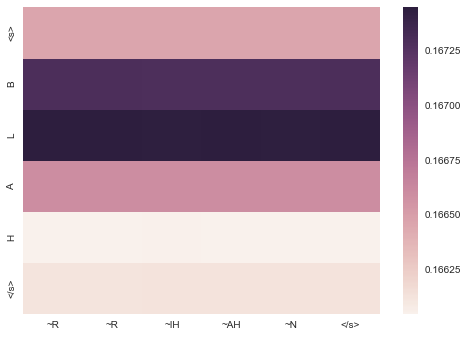

= R R IH AH N  
> quit


In [31]:
interactive_session(model, vocab, i2w, show_attention=True)

_unchecked_

注意, 注意权重如何显示输入的不同部分在输出中生成不同的标记是多么重要。对于像机器翻译这样的任务, 由于语言之间的语法差异, 一到一词的顺序经常会发生变化, 这一点变得非常有趣, 因为我们看到的注意力窗口离对角线更远了, 它主要显示在字形到音素的翻译。

**下一步**

使用上面的模型, 您可以在许多不同的域中训练一个功能强大的序列到序列模型。唯一需要的主要更改是准备一个具有对输入和输出序列的数据集, 通常, 其余的构建块将保持不变。祝你好运, 玩得开心!